## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
# use %autoreload command to reload all libraries

In [2]:
from IPython.core.debugger import set_trace
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"

In [3]:
# Python path fixing so we can import libraries
import sys
import os
sys_paths = ['../', # 
            ]
for p in sys_paths:
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

In [9]:
import hands.data
from hands.data import *
# import hands.multiloss
from hands.multiloss import *
from hands.hands_loss import *
from hands.notebook_utils import *
from hands.utils import * 
from hands.models.model_darknet_customized import *

In [5]:
_ = torch.manual_seed(42); np.random.seed(42); random.seed(42)

In [6]:
print(f"Pytorch: {torch.__version__}, Torchvision: {torchvision.__version__}, Fastai: {fastai.__version__}")

Pytorch: 1.0.0.dev20181009, Torchvision: 0.2.1, Fastai: 1.0.25.dev0


In [7]:
%autoreload

## Test Data

In [8]:
img_fnames_test = glob.glob('../data/test/**/*.jpg', recursive=True)
len(img_fnames_test)

4723

In [14]:
databunch = get_default_databunch([img_fnames_test,[],[]], size=320)
ds = databunch.train_ds
ds.return_data = False

### Examples of Data

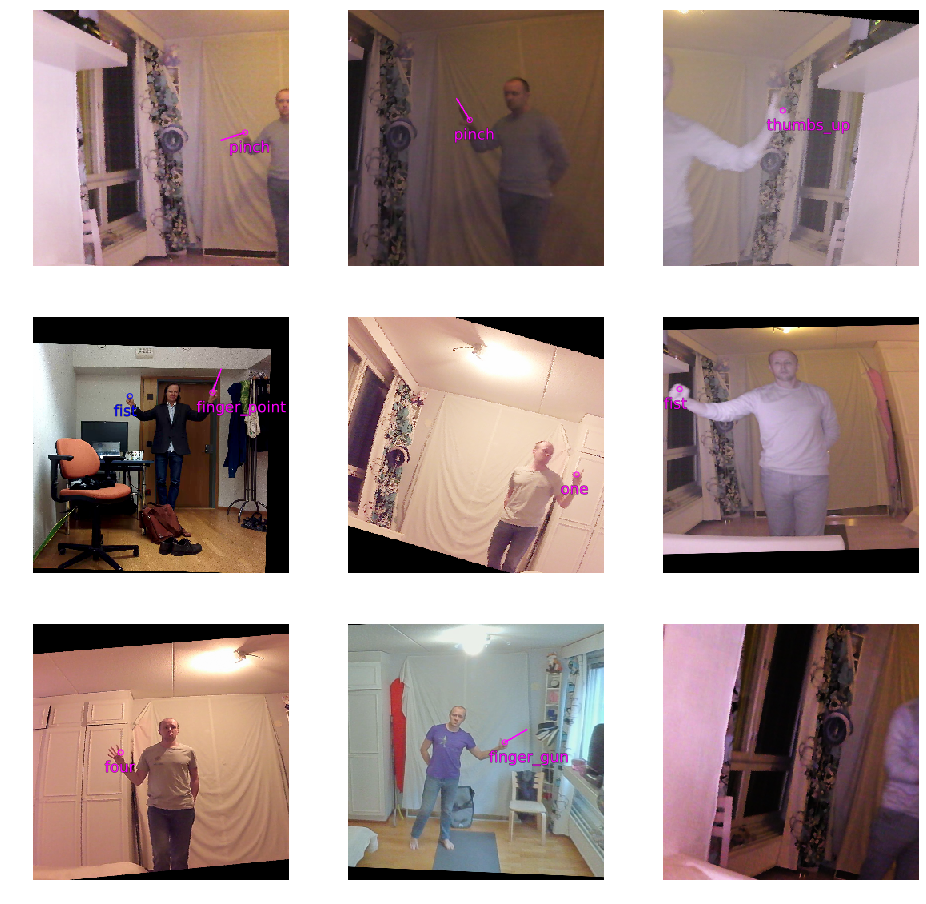

In [18]:
_, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    idx = random.randint(0, len(img_fnames_test))
    a1, a2 = ds[idx]
    a2.show(a1, ax=ax, figsize=(3,3), lw=1)

### Examples of Augmentations with Single Image

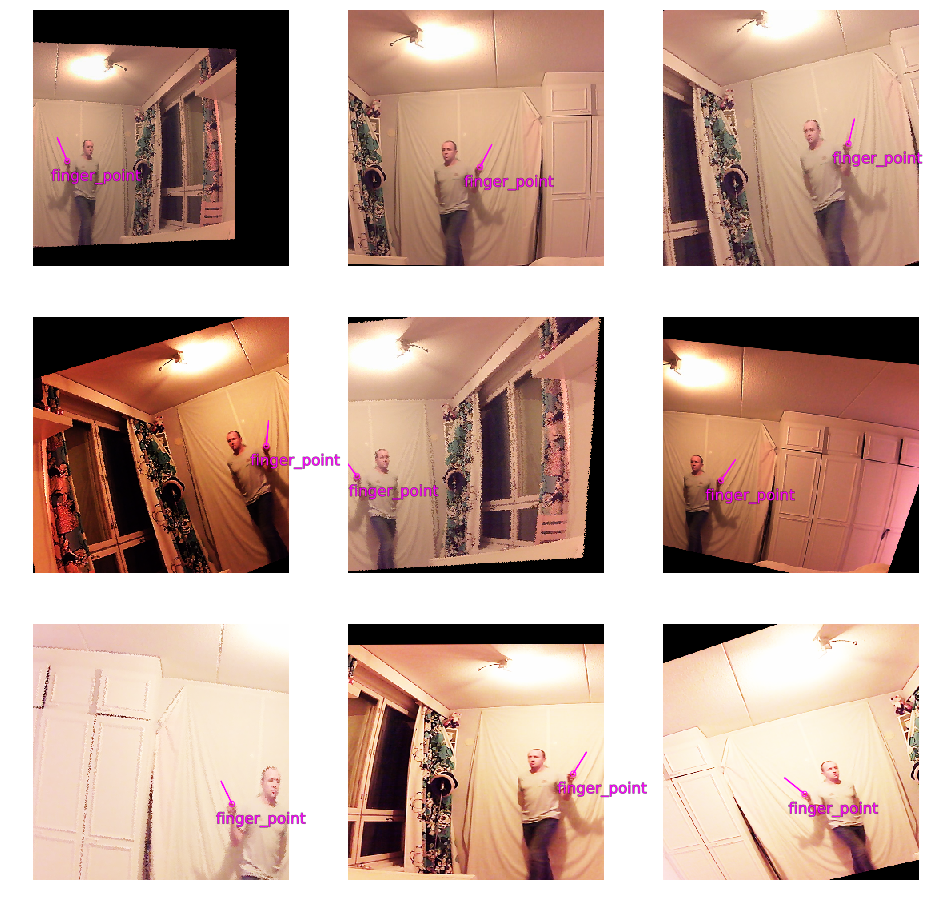

In [23]:
idx = random.randint(0, len(img_fnames_test))
_, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    a1, a2 = ds[idx]
    a2.show(a1, ax=ax, figsize=(3,3), lw=1)

# Prediction Examples

In [35]:
model = ModelDarknetCustomized.load_default_full_512(models_path="../data/models/")
model = model.cuda()

In [56]:
# No img augment here
_ = fastai.vision.get_transforms()[1]
databunch = get_default_databunch([img_fnames_test,img_fnames_test,[]], tfms_arr=[_, _], size=512, bs=16)

In [62]:
it = iter(databunch.train_dl)

In [68]:
img_tensors, targets = next(it)

In [69]:
results = predict_img(model, img_tensors.cuda())

In [70]:
results[1]

[[11,
  0.6740060970187187,
  0.3251545298844576,
  -0.6599718,
  -0.75129044,
  0.9573585391044617,
  0.9999988079071045]]

**First number is objectness score, sceond one is class score. So mainly "Is there a hand" and "Which class is it"**

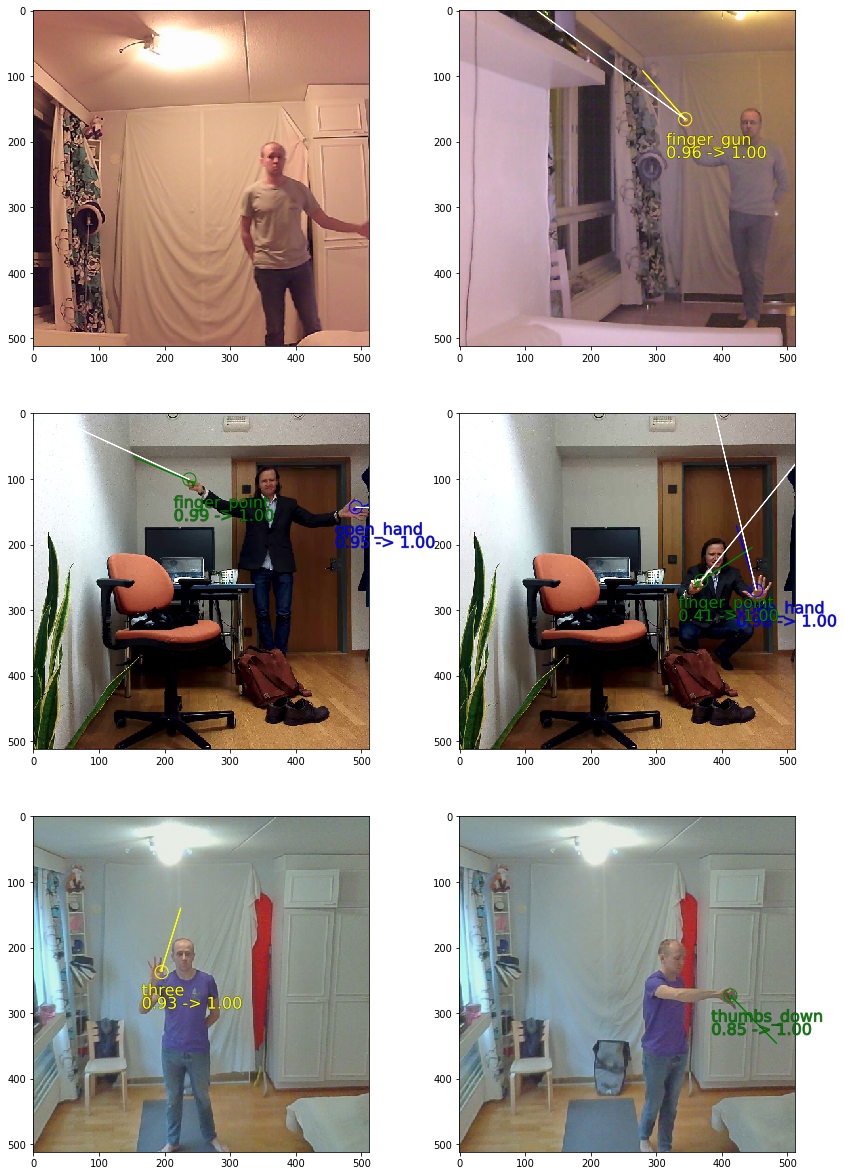

In [71]:
plot_results(img_tensors[:6], results, targets=targets)

## Accuracy and Examples of Wrong Predictions

**Here we are using varying width in the images. Shorter edge is resized to 512 and longer edge is cut to be divisible by 32.**

In [ ]:
corr, wrongs, w_samples, w_idxs = calculate_accuracy_files(model, img_fnames_test, 512, max_samples=64,
                                                           get_results_args={'conf_thresh': .20})

In [78]:
corr, wrongs

(0.7355494389159433,
 {'not_enough_preds': 210,
  'too_many_preds': 42,
  'wrong_class': 527,
  'too_far': 1,
  'wrong_direction': 469})

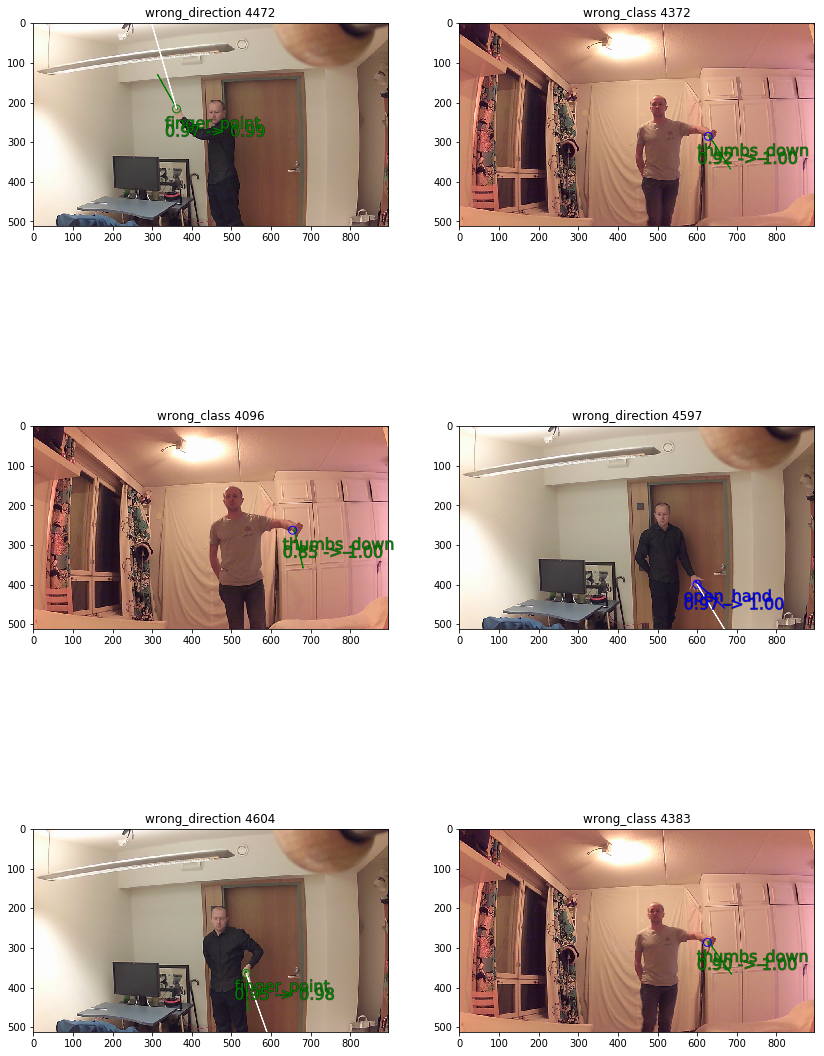

In [75]:
i=50; j=6
plot_results(*list(zip(*w_samples[i:i+j])))

In [79]:
corr, wrongs, w_samples, w_idxs = calculate_accuracy_files(model, img_fnames_test, 512, max_samples=64,
                                                           get_results_args={'conf_thresh': .20})
corr, wrongs

(0.7355494389159433,
 {'not_enough_preds': 210,
  'too_many_preds': 42,
  'wrong_class': 527,
  'too_far': 1,
  'wrong_direction': 469})

In [80]:
corr, wrongs, w_samples, w_idxs = calculate_accuracy_files(model, img_fnames_test, 512, max_samples=64,
                                                           get_results_args={'conf_thresh': .40})
corr, wrongs

(0.7124708871479991,
 {'not_enough_preds': 462,
  'too_many_preds': 8,
  'wrong_class': 468,
  'too_far': 1,
  'wrong_direction': 419})

In [81]:
corr, wrongs, w_samples, w_idxs = calculate_accuracy_files(model, img_fnames_test, 512, max_samples=64,
                                                           get_results_args={'conf_thresh': .60})
corr, wrongs

(0.6478932881643024,
 {'not_enough_preds': 918,
  'too_many_preds': 1,
  'wrong_class': 386,
  'too_far': 0,
  'wrong_direction': 358})

Depending on the settings. We get most of the time the right result. We defined the prediction correct if all detections are the right class, not more than 5% from correct point and no more than 10 degrees difference in the angle